### Step 1: Install and Import Required Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import importlib
from tqdm import tqdm

# import models
import hopfield_baseline
import hopfield_PSL_final
import storkey
import spiking
import grayscaled_hp_baseline

## Method 1 CIFAR-10 Data Preprocessing

### Step 2: Load the CIFAR-10 Dataset

In [2]:
# defining a transform for converting images to grayscale and tensors
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
color_trainset = datasets.CIFAR10(root='./data', train=True, download=True)

print(f'Training set size: {len(train_dataset)}')

Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000


### Step 3: Binarize the Images to -1/+1

In [3]:
# convert images to numpy arrays
train_images = torch.stack([img for img,_ in train_dataset]).numpy()

# binarize the images
train_images = np.where(train_images > 0.5, 1, -1)

# verify the range of values
print(f'Unique pixel values after binarization: {np.unique(train_images)}')

Unique pixel values after binarization: [-1  1]


### Step 4: Reshape Images into 1024-bit Vectors

In [4]:
train_images = train_images.reshape(len(train_images), -1)

### Step 6: Visualize Some Binarized Images

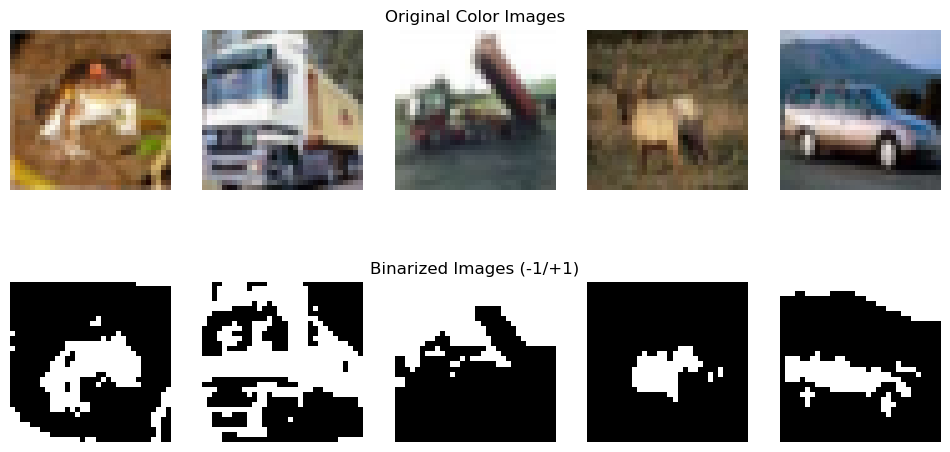

In [5]:
num_images = 5
fig, axes = plt.subplots(2,num_images,figsize=(12,6))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')

plt.show()

### Step 7: Generate a Corrupted Subset of Training Images

In [6]:
def corrupt_images(images, corruption_type="mask ", corruption_fraction=0.25):
    """
    Corrupt images by either masking pixels or flipping them

    Args:
        images (numpy array): binarized images to corrupt
        corruption_type (str): "mask" to set pixels to 0, "flip" to invert pixels
        corruption_fraction (float): Fraction of pixels to corrupt

    Returns:
        numpy array: Corrupted images
    """
    corrupted_images = images.copy()
    num_pixels = images.shape[1]
    num_corrupt = int(corruption_fraction * num_pixels)

    for img in corrupted_images:
        corrupt_indices = np.random.choice(num_pixels, num_corrupt, replace=False)

        if corruption_type == 'mask':
            img[corrupt_indices] = 0
        elif corruption_type == 'flip':
            img[corrupt_indices] *= -1
    return corrupted_images

In [7]:
# create corrupted images to use as test set
masked_images = corrupt_images(train_images, corruption_type='mask', corruption_fraction=0.25)
flipped_images = corrupt_images(train_images, corruption_type='flip', corruption_fraction=0.25)

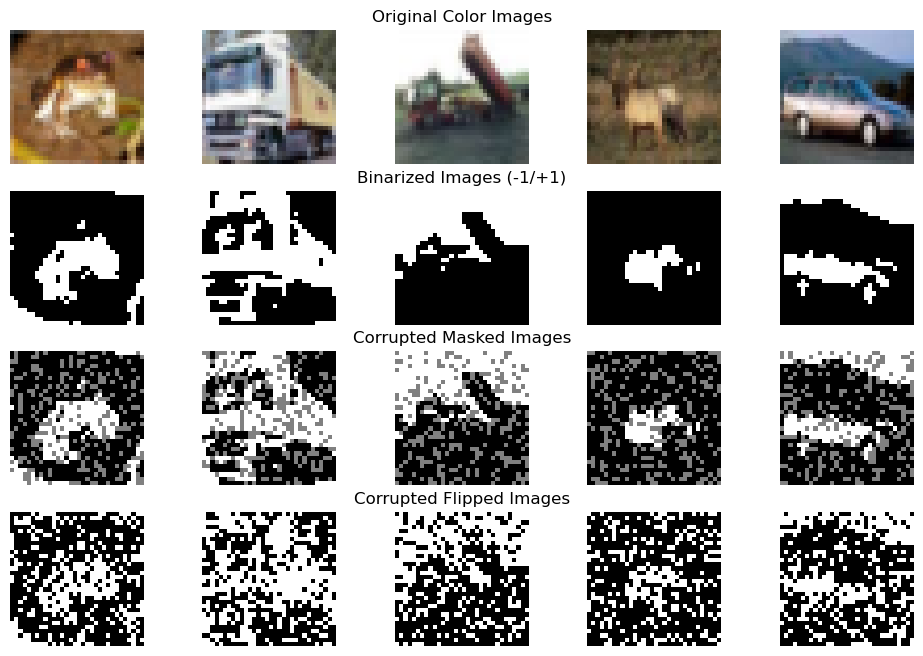

In [8]:
# Visualize some corrupted images

num_images = 5
fig, axes = plt.subplots(4,num_images,figsize=(12,8))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

    # Plot corrupted masked images
    axes[2,i].imshow(masked_images[i].reshape(32,32), cmap='gray')
    axes[2,i].axis('off')

    # Plot corrupted flipped images
    axes[3,i].imshow(flipped_images[i].reshape(32,32), cmap='gray')
    axes[3,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')
axes[2,num_images//2].set_title('Corrupted Masked Images', fontsize=12, loc='center')
axes[3,num_images//2].set_title('Corrupted Flipped Images', fontsize=12, loc='center')


plt.show()

### Step 8: Save the Preprocessed Datasets

In [ ]:
# Create 'data/binarized' directory if it doesn't exist
if not os.path.isdir('data/binarized'):
    os.mkdir('data/binarized')

np.save("data/binarized/train_images.npy", train_images)
np.save("data/binarized/masked_images.npy", masked_images)
np.save("data/binarized/flipped_images.npy", flipped_images)

## Method 2 CIFAR-10 Data Preprocessing

### Step 9: Save Grayscale Images

In [10]:
importlib.reload(grayscaled_hp_baseline)

# Create directory to save grayscale images
save_dir = 'data/grayscale_images'
os.makedirs(save_dir, exist_ok=True)

# convert grayscale encoded images to numpy arrays
encoded_images = torch.stack([grayscaled_hp_baseline.encode(img) for img,_ in train_dataset]).numpy()

masked_gray_images = corrupt_images(encoded_images, corruption_type='mask', corruption_fraction=0.25)
flipped_gray_images = corrupt_images(encoded_images, corruption_type='flip', corruption_fraction=0.25)

print(f'Training set size: {len(encoded_images)}')
np.save(os.path.join(save_dir, "train_images.npy"), encoded_images)
np.save(os.path.join(save_dir, "masked_images.npy"), masked_gray_images)
np.save(os.path.join(save_dir, "flipped_images.npy"), flipped_gray_images)

Training set size: 50000


## Training Baseline

### Method 1

In [2]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

In [3]:
importlib.reload(hopfield_baseline)

num_neurons = 1024
num_patterns = 5
hopfield_rnn = hopfield_baseline.HopfieldRNN(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = stored_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_rnn.store_patterns(baseline_original)

In [5]:
# Retrieve images from corrupted inputs
retrieved_masked = hopfield_rnn(baseline_masked)
retrieved_flipped = hopfield_rnn(baseline_flipped)

In [6]:
# Compute MSE Loss
loss_masked = hopfield_rnn.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_rnn.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}")

print('-'*50)

# Compute accuracy
masked_acc = hopfield_rnn.recall_accuracy(baseline_masked, baseline_original)
flipped_acc = hopfield_rnn.recall_accuracy(baseline_flipped, baseline_original)

print(f"Reconstruction Accuracy (Masked Images): {masked_acc:.4f}")
print(f"Reconstruction Accuracy (Flipped Images): {flipped_acc:.4f}")

Reconstruction MSE Loss (Masked Images): 0.2102
Reconstruction MSE Loss (Flipped Images): 0.2352
--------------------------------------------------
Reconstruction Accuracy (Masked Images): 0.4000
Reconstruction Accuracy (Flipped Images): 0.4000


In [4]:
def plot_comparisons(original, corrupted, retrieved, title_corrupted, title_retrieved, num_samples=5):

    fig, axes = plt.subplots(3, num_samples, figsize=(12, 8))

    for i in range(num_samples):
        # Original stored image
        axes[0, i].imshow(original[i].reshape(32, 32), cmap='gray')
        axes[0, i].axis('off')

        # Corrupted image
        axes[1, i].imshow(corrupted[i].reshape(32, 32), cmap='gray')
        axes[1, i].axis('off')

        # Retrieved image
        axes[2, i].imshow(retrieved[i].reshape(32, 32), cmap='gray')
        axes[2, i].axis('off')

    # Add row titles
    axes[0, 0].set_title("Original Stored Images", fontsize=12, loc='center')
    axes[1, 0].set_title(title_corrupted, fontsize=12, loc='center')
    axes[2, 0].set_title(title_retrieved, fontsize=12, loc='center')

    plt.show()

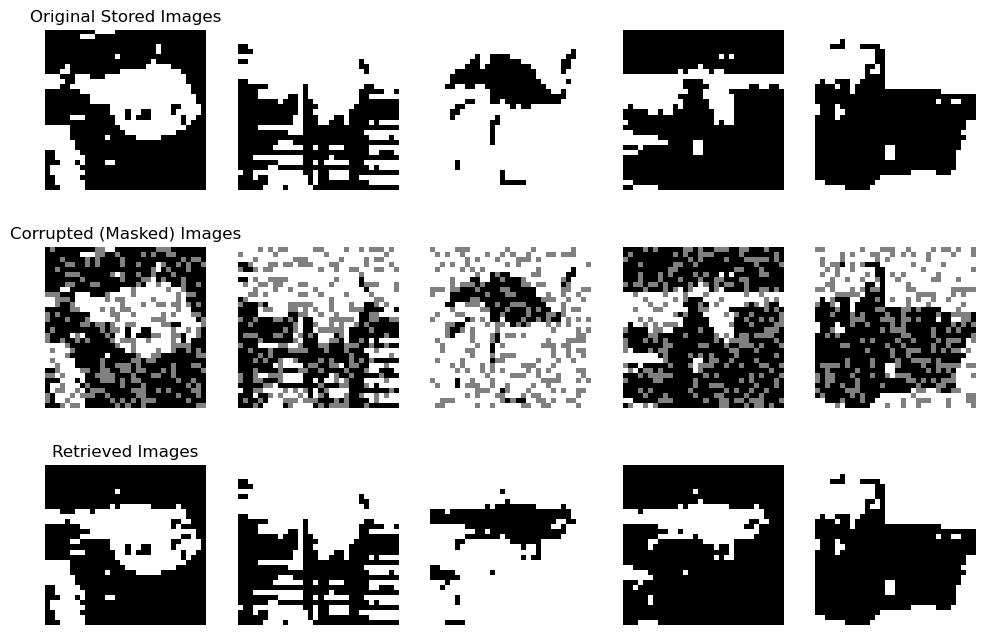

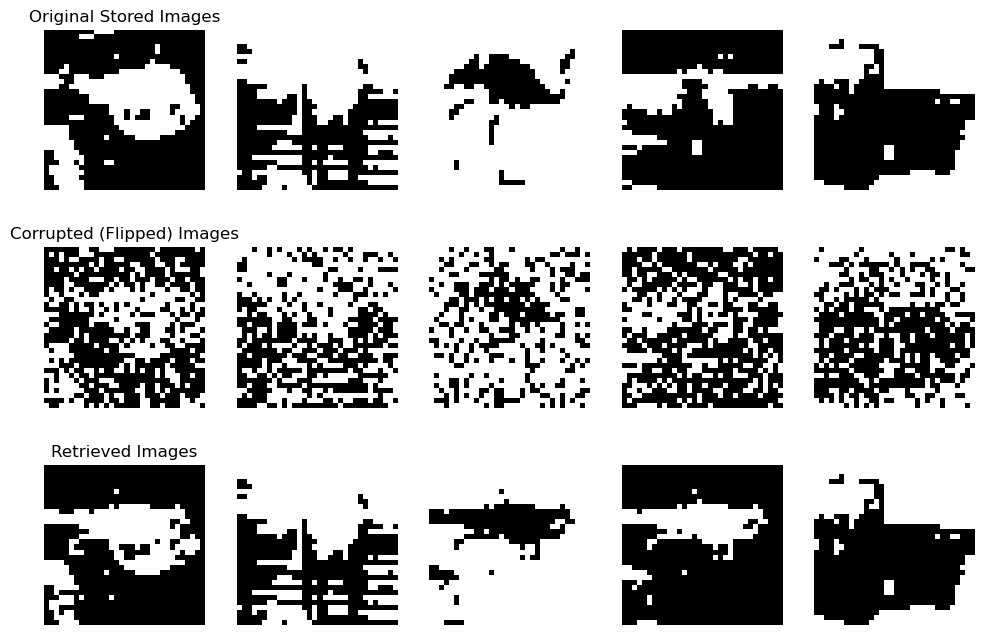

In [7]:
# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked.detach().numpy(),
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped.detach().numpy(),
                 "Corrupted (Flipped) Images", "Retrieved Images")


#### Reconstructing Images for Increasing Stored Patterns

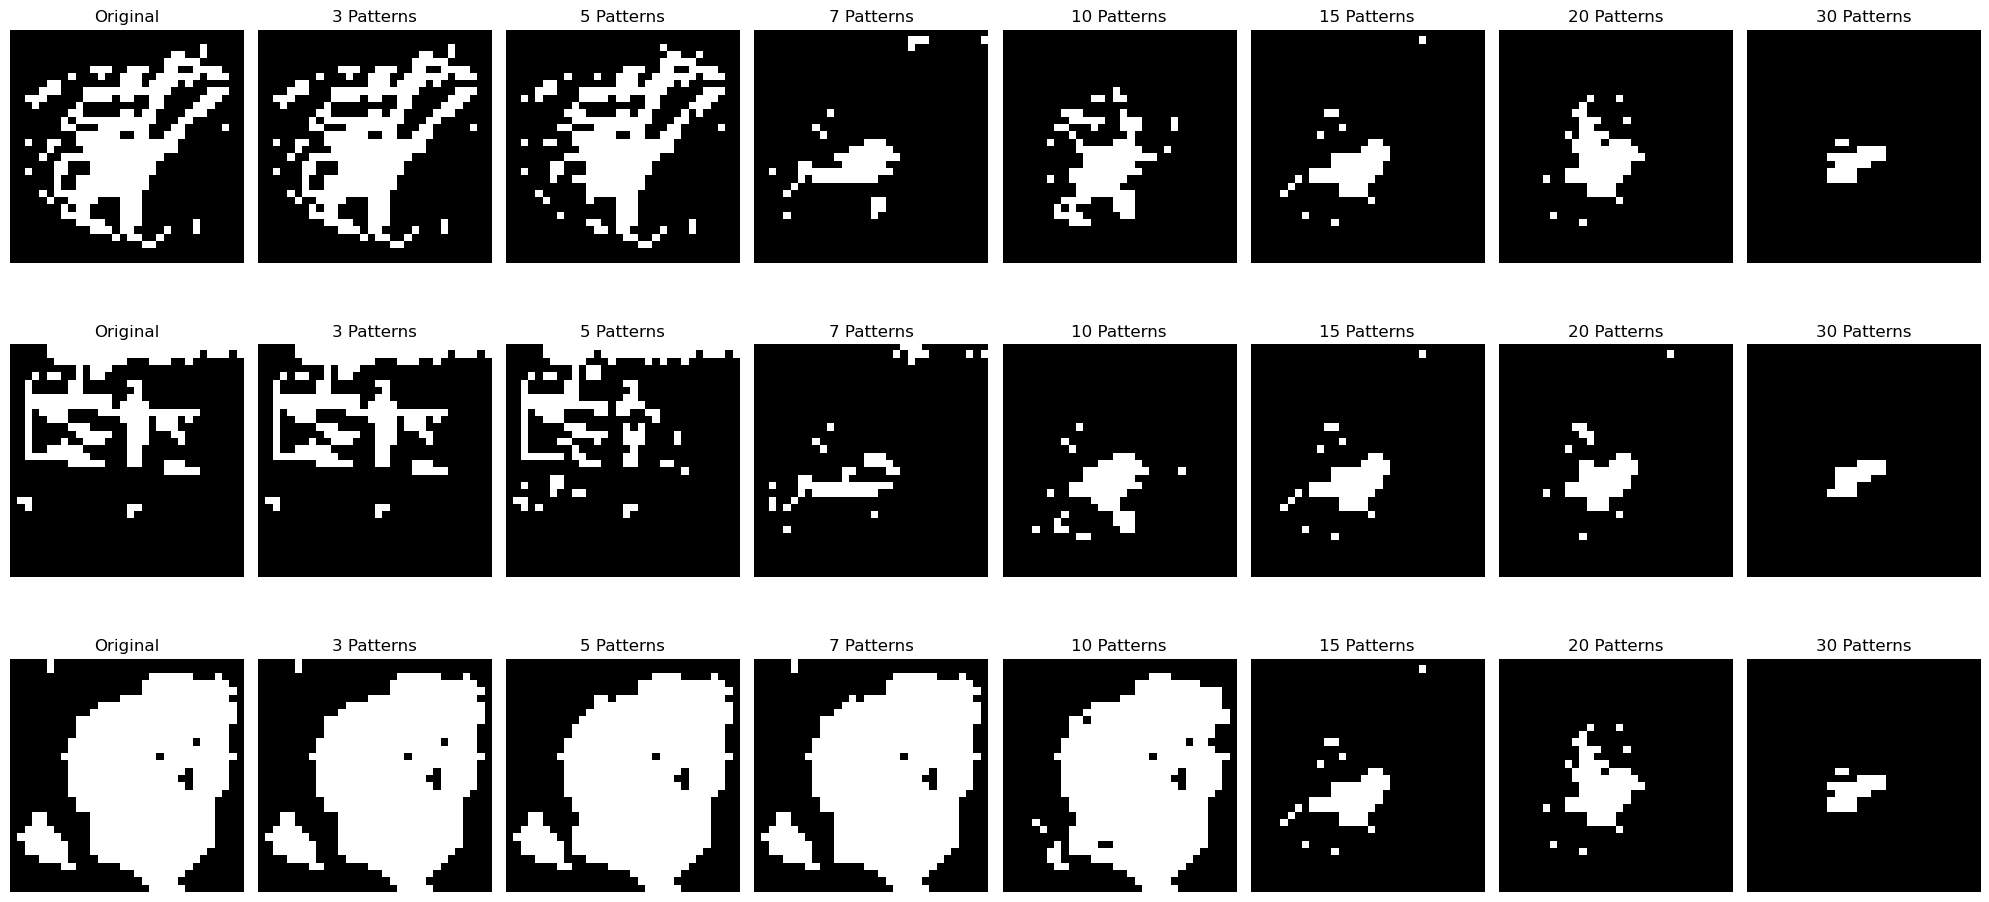

In [24]:
results = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30]
selected_idxs = set()
plot_idx = []
prev_num = 0

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_rnn = hopfield_baseline.HopfieldRNN(num_units=1024)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=(num_patterns-prev_num), replace=False)
    prev_num = num_patterns

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_rnn.store_patterns(baseline_original)

    retrieved_masked = hopfield_rnn(baseline_masked)

    # Store the results for plotting later
    results.append(retrieved_masked.detach().numpy())

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


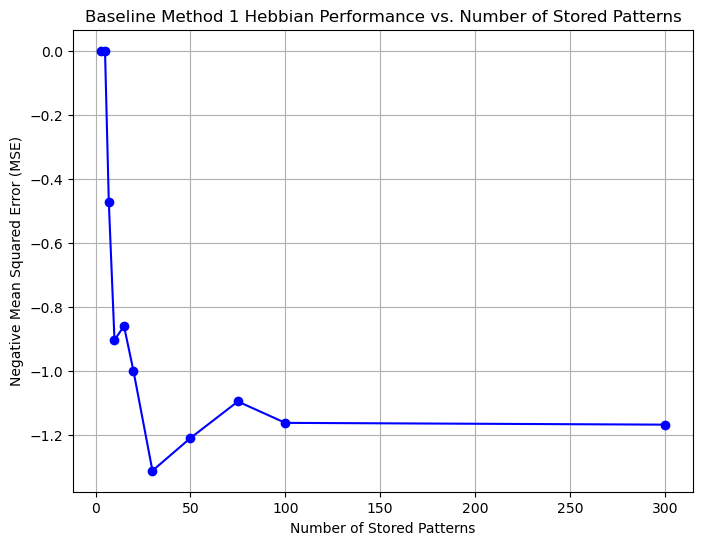

In [8]:
hebb_m1_results = []
hebb_m1_mse_values = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 75, 100, 300]

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_rnn = hopfield_baseline.HopfieldRNN(num_units=1024)

    # randomly select from training set
    idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

    baseline_original = stored_images[idxs]
    baseline_masked = masked_images[idxs]

    hopfield_rnn.store_patterns(baseline_original)

    retrieved_masked = hopfield_rnn(baseline_masked)
    # loss = nn.MSELoss(retrieved_masked, baseline_original)
    loss = hopfield_rnn.recall_loss(baseline_masked, baseline_original)

    # Store the results for plotting later
    hebb_m1_results.append(retrieved_masked.detach().numpy())
    hebb_m1_mse_values.append(loss.detach().numpy())


# Plot the negative MSE curve (to make it appear decreasing)
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, [-mse for mse in hebb_m1_mse_values], marker='o', linestyle='-', color='b')  # Negative SSE values
plt.title("Baseline Method 1 Hebbian Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.grid(True)
plt.show()

### Method 2 

Reconstruction MSE Loss (Masked Images): 0.0051
Reconstruction MSE Loss (Flipped Images): 0.0053


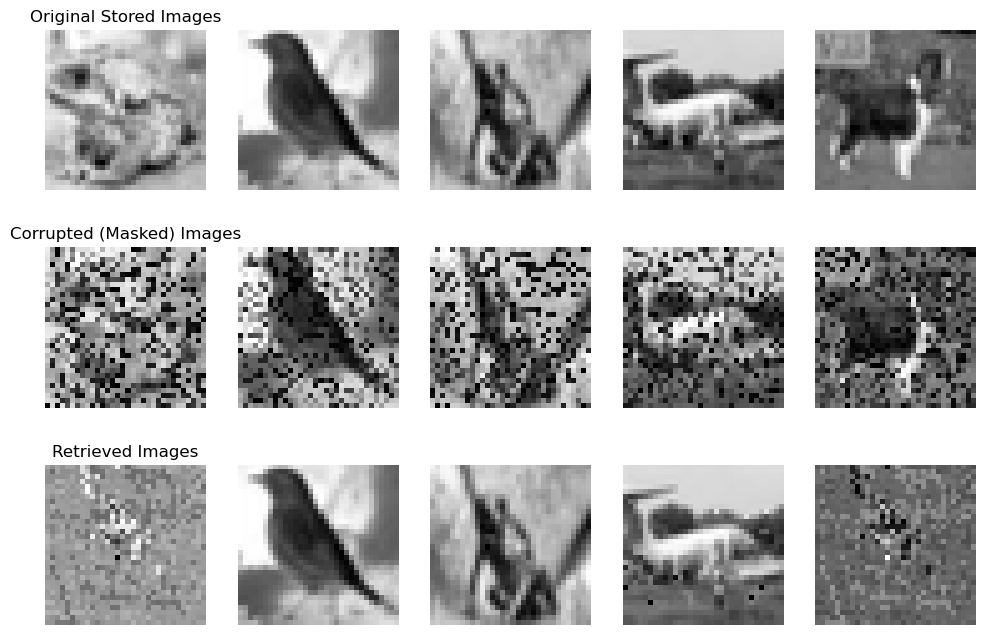

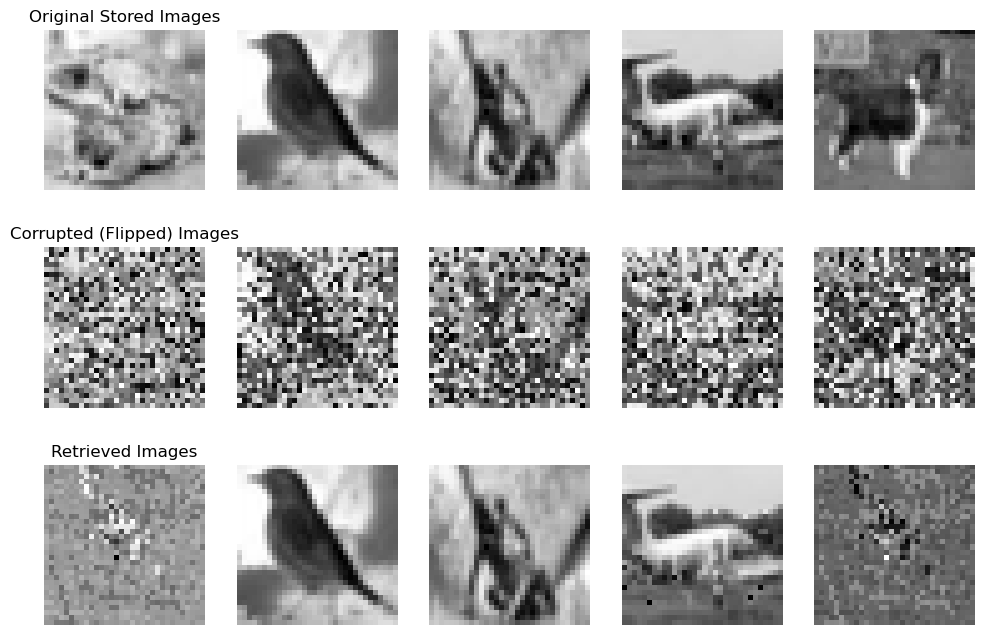

In [9]:
# Method 2 Preprocessing


# load training data
stored_images = np.load("data/grayscale_images/train_images.npy")
masked_images = np.load("data/grayscale_images/masked_images.npy")
flipped_images = np.load("data/grayscale_images/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

importlib.reload(hopfield_baseline)
importlib.reload(grayscaled_hp_baseline)

num_neurons = 8192
num_patterns = 45
hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscale(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = stored_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_gray.store_patterns(baseline_original)


# Retrieve images from corrupted inputs
retrieved_masked = hopfield_gray(baseline_masked).detach()
retrieved_flipped = hopfield_gray(baseline_flipped).detach()

# Convert back to grayscale
retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])
retrieved_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_flipped])

# Compute MSE Loss
loss_masked = hopfield_gray.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_gray.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}")

baseline_original = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_original])
baseline_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_masked])
baseline_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_flipped])

# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked,
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped,
                 "Corrupted (Flipped) Images", "Retrieved Images")


#### Reconstructing Images for Increasing Stored Patterns

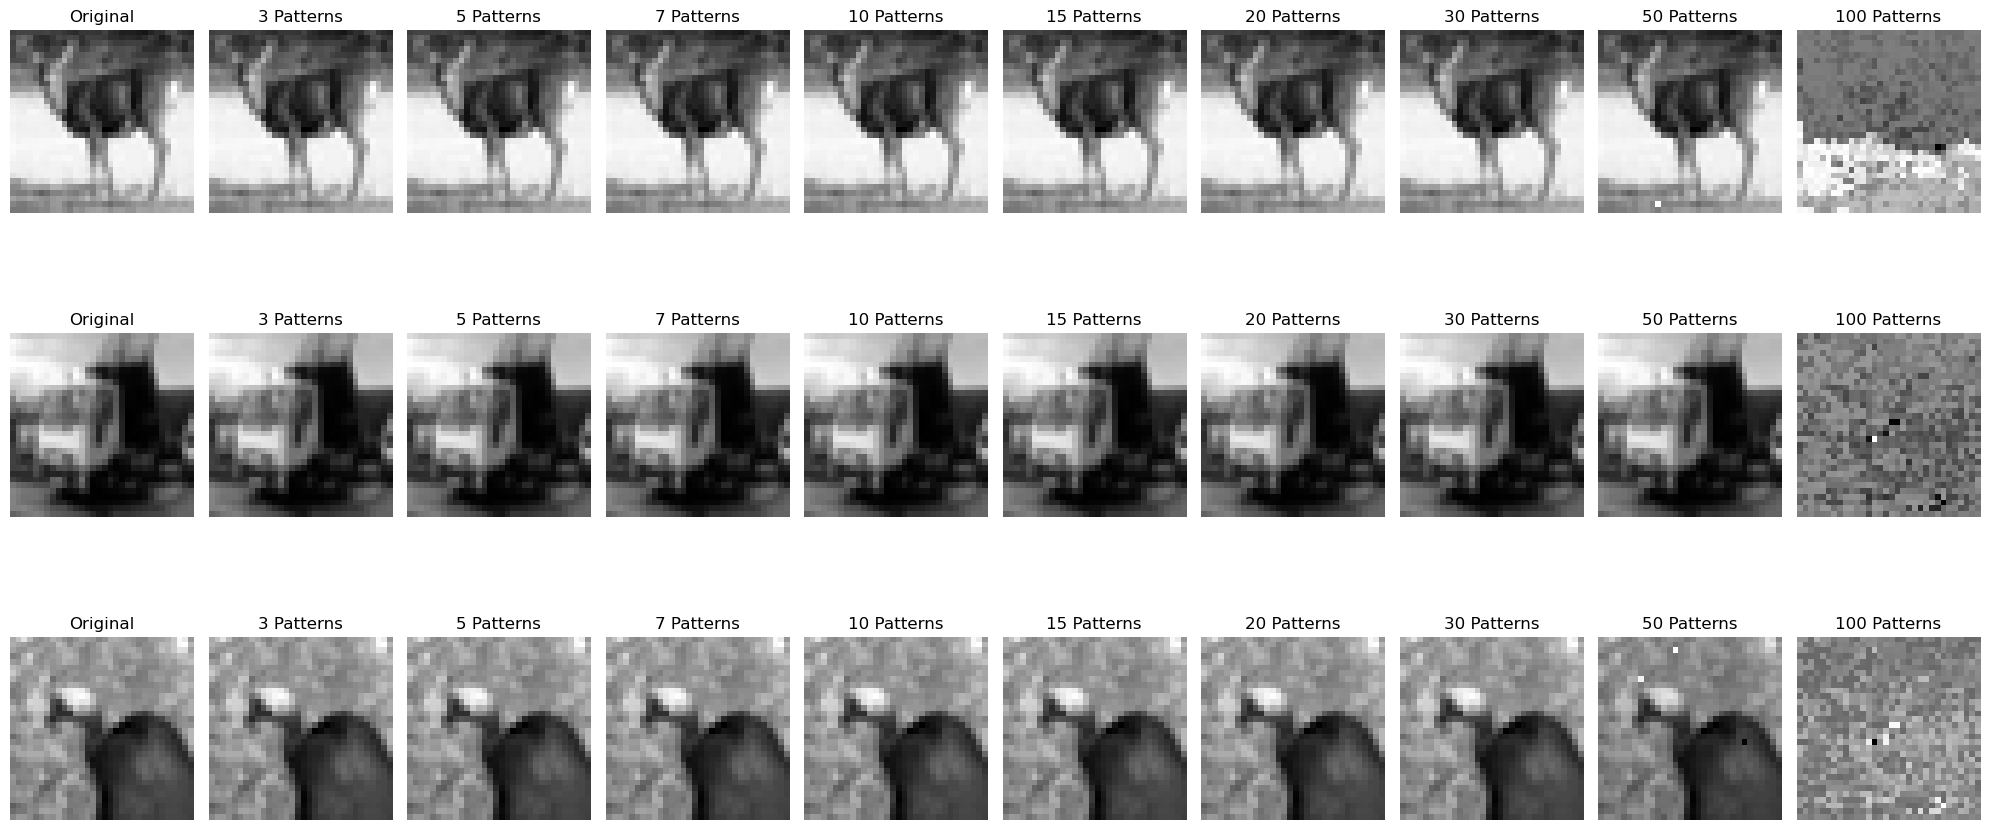

In [57]:
results = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100]
selected_idxs = set()
plot_idx = []
prev_num = 0

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscale(num_units=8192)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=(num_patterns-prev_num), replace=False)
    prev_num = num_patterns

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_gray.store_patterns(baseline_original)

    # Retrieve images from corrupted inputs
    retrieved_masked = hopfield_gray(baseline_masked).detach()

    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])

    # Store the results for plotting later
    results.append(retrieved_masked)

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(grayscaled_hp_baseline.decode(stored_images[plot_idx[row-1]]), cmap='gray')
    # plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


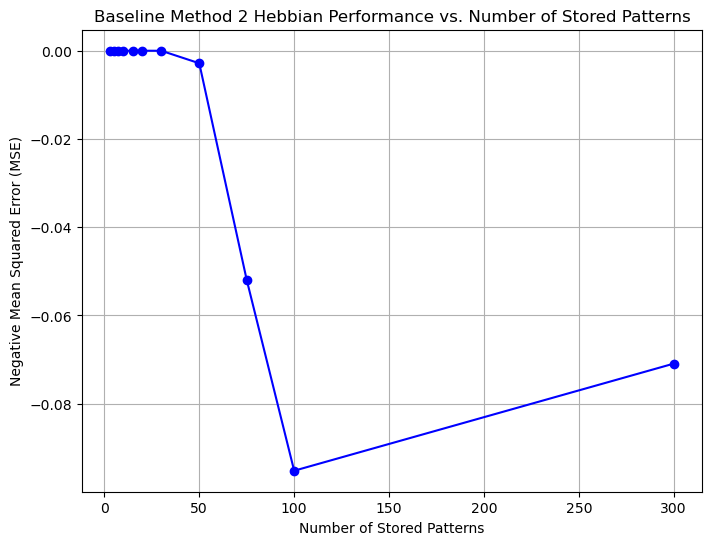

In [10]:

hebb_m2_results = []
hebb_m2_mse_values = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 75, 100, 300]

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscale(num_units=8192)

    # randomly select from training set
    idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

    baseline_original = stored_images[idxs]
    baseline_masked = masked_images[idxs]

    hopfield_gray.store_patterns(baseline_original)

    retrieved_masked = hopfield_gray(baseline_masked).detach()
    
    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])


    loss = hopfield_gray.recall_loss(baseline_masked, baseline_original)

    # Store the results for plotting later
    hebb_m2_results.append(retrieved_masked.detach().numpy())
    hebb_m2_mse_values.append(loss.detach().numpy())


# Plot the negative MSE curve (to make it appear decreasing)
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, [-mse for mse in hebb_m2_mse_values], marker='o', linestyle='-', color='b')  # Negative SSE values
plt.title("Baseline Method 2 Hebbian Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.grid(True)
plt.show()

### Funny Tanh

Reconstruction MSE Loss (Masked Images): 0.0041
Reconstruction MSE Loss (Flipped Images): 0.0083


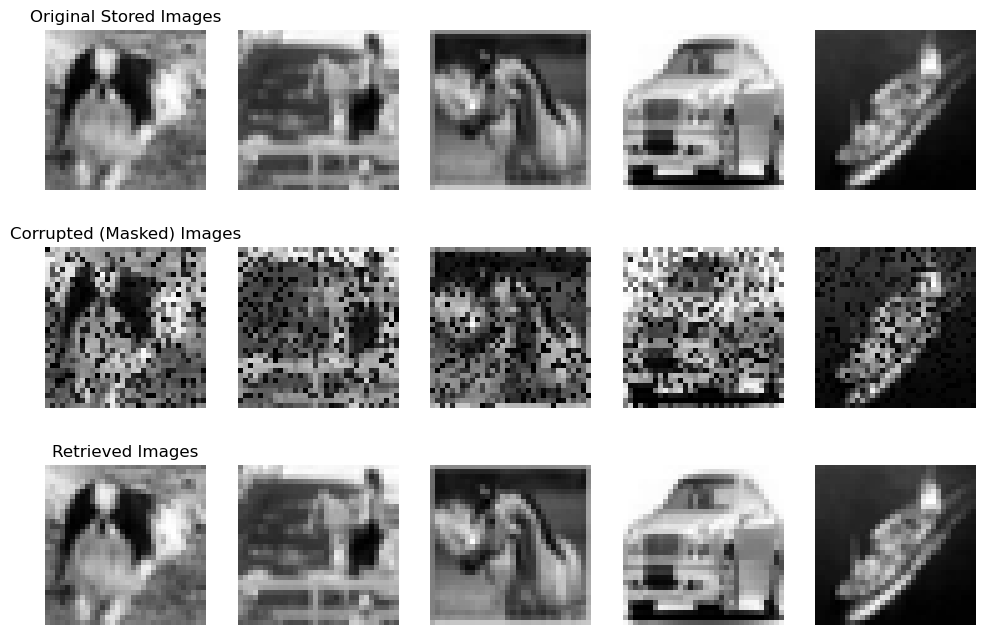

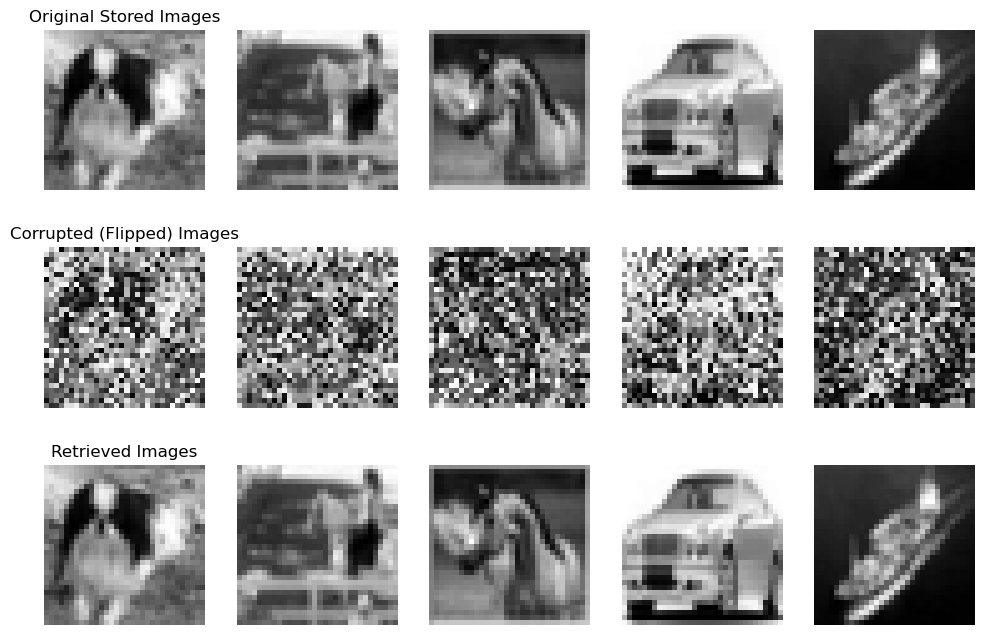

In [11]:
# Method 2 Preprocessing


# load training data
stored_images = np.load("data/grayscale_images/train_images.npy")
masked_images = np.load("data/grayscale_images/masked_images.npy")
flipped_images = np.load("data/grayscale_images/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

importlib.reload(hopfield_baseline)
importlib.reload(grayscaled_hp_baseline)

num_neurons = 8192
num_patterns = 50
hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscaleTANH(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = stored_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_gray.store_patterns(baseline_original)


# Retrieve images from corrupted inputs
retrieved_masked = hopfield_gray(baseline_masked).detach()
retrieved_flipped = hopfield_gray(baseline_flipped).detach()

# Convert back to grayscale
retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])
retrieved_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_flipped])

# Compute MSE Loss
loss_masked = hopfield_gray.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_gray.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}")

baseline_original = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_original])
baseline_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_masked])
baseline_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_flipped])

# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked,
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped,
                 "Corrupted (Flipped) Images", "Retrieved Images")


#### Reconstructing Images for Increasing Stored Patterns

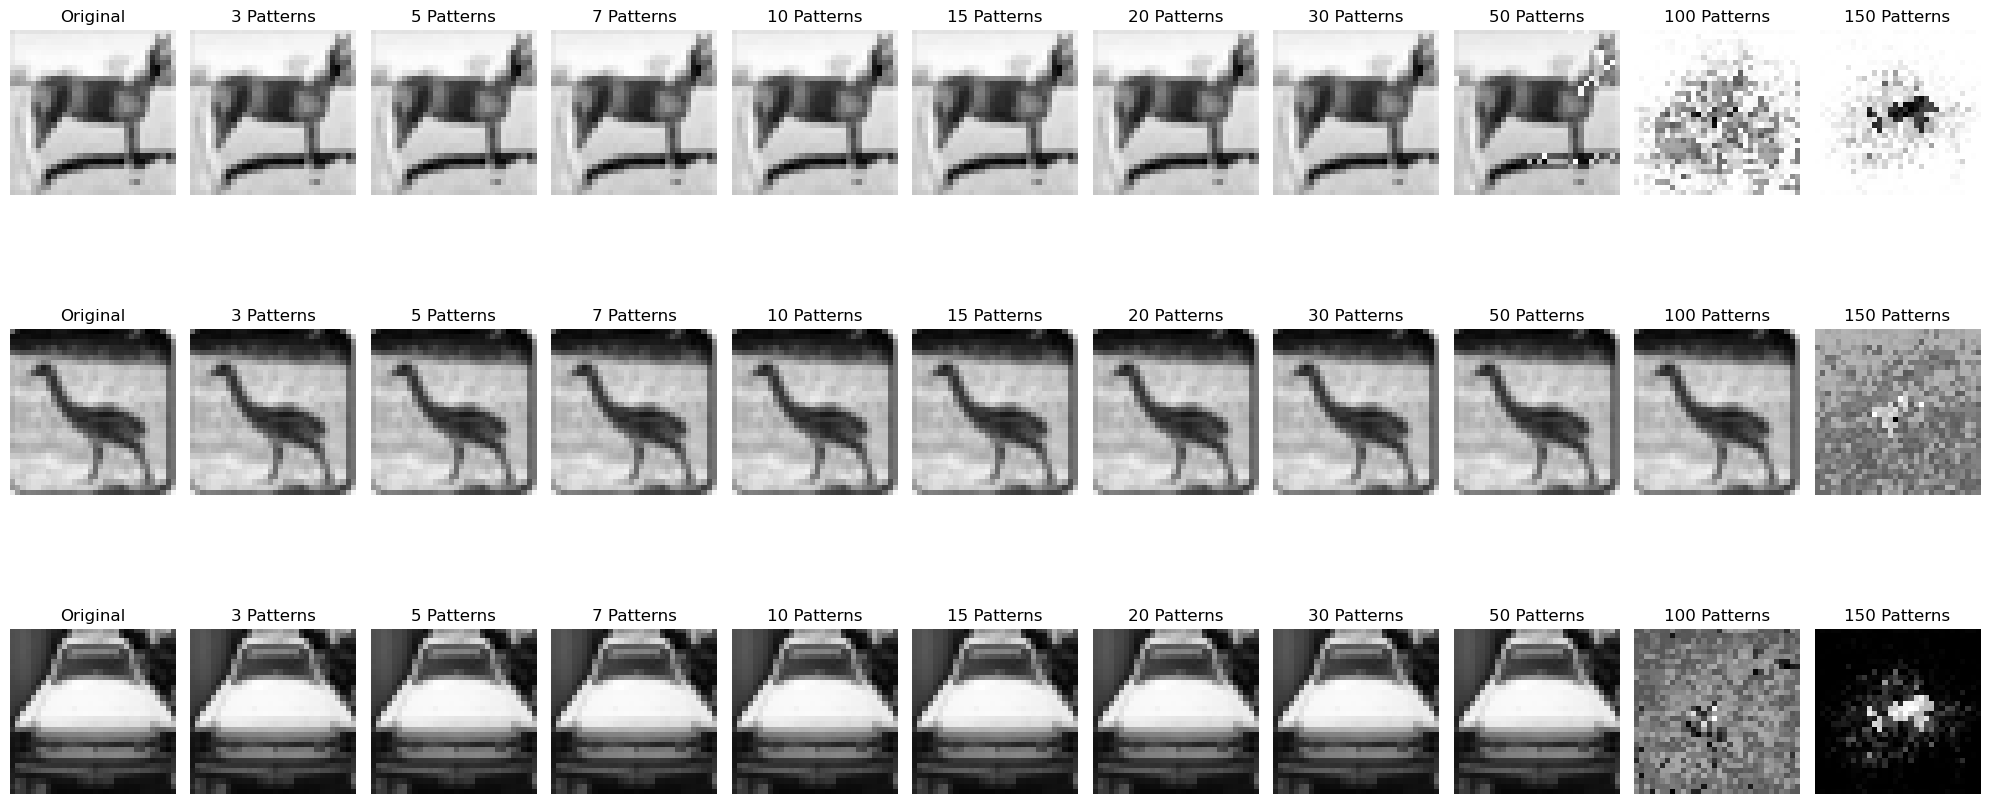

In [31]:
results = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100, 150]
selected_idxs = set()
plot_idx = []
prev_num = 0

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscaleTANH(num_units=8192)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=(num_patterns-prev_num), replace=False)
    prev_num = num_patterns

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_gray.store_patterns(baseline_original)

    # Retrieve images from corrupted inputs
    retrieved_masked = hopfield_gray(baseline_masked).detach()

    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])

    # Store the results for plotting later
    results.append(retrieved_masked)

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(grayscaled_hp_baseline.decode(stored_images[plot_idx[row-1]]), cmap='gray')
    # plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


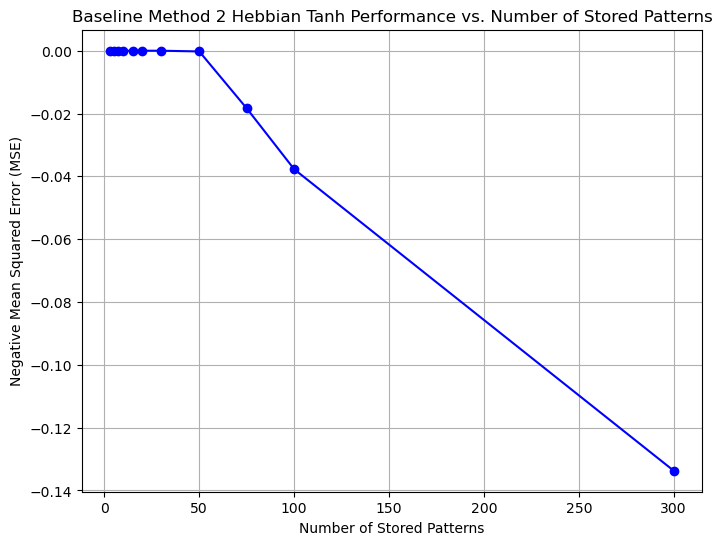

In [12]:

tanh_m2_results = []
tanh_m2_mse_values = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 75, 100, 300]

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_gray = grayscaled_hp_baseline.HopfieldRNNGrayscaleTANH(num_units=8192)

    # randomly select from training set
    idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

    baseline_original = stored_images[idxs]
    baseline_masked = masked_images[idxs]

    hopfield_gray.store_patterns(baseline_original)

    retrieved_masked = hopfield_gray(baseline_masked).detach()
    
    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])


    loss = hopfield_gray.recall_loss(baseline_masked, baseline_original)

    # Store the results for plotting later
    tanh_m2_results.append(retrieved_masked.detach().numpy())
    tanh_m2_mse_values.append(loss.detach().numpy())


# Plot the negative MSE curve (to make it appear decreasing)
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, [-mse for mse in tanh_m2_mse_values], marker='o', linestyle='-', color='b')  # Negative SSE values
plt.title("Baseline Method 2 Hebbian Tanh Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.grid(True)
plt.show()



## Training Storkey Model

### Method 1

In [30]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

In [26]:
importlib.reload(storkey)

num_neurons = 1024
num_patterns = 30
hopfield_storkey = storkey.HopfieldStorkey(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = stored_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_storkey.store_patterns(baseline_original)

In [27]:
# Retrieve images from corrupted inputs
retrieved_masked = hopfield_storkey(baseline_masked)
retrieved_flipped = hopfield_storkey(baseline_flipped)

In [28]:
# Compute MSE Loss
loss_masked = hopfield_storkey.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_storkey.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}")

print('-'*50)

# Compute accuracy
masked_acc = hopfield_storkey.recall_accuracy(baseline_masked, baseline_original)
flipped_acc = hopfield_storkey.recall_accuracy(baseline_flipped, baseline_original)

print(f"Reconstruction Accuracy (Masked Images): {masked_acc:.4f}")
print(f"Reconstruction Accuracy (Flipped Images): {flipped_acc:.4f}")

Reconstruction MSE Loss (Masked Images): 0.4187
Reconstruction MSE Loss (Flipped Images): 0.4199
--------------------------------------------------
Reconstruction Accuracy (Masked Images): 0.4667
Reconstruction Accuracy (Flipped Images): 0.4667


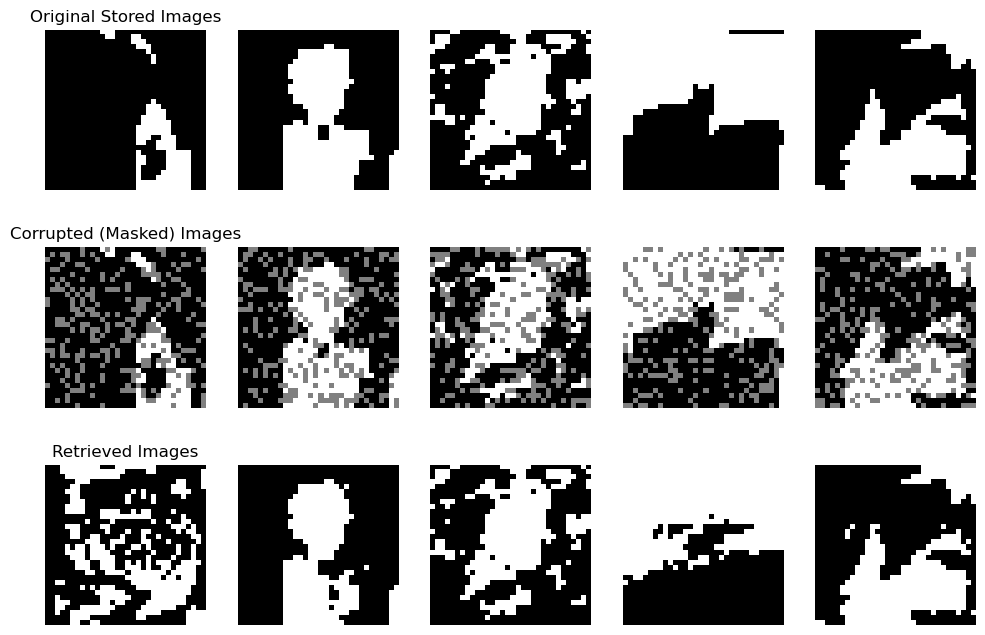

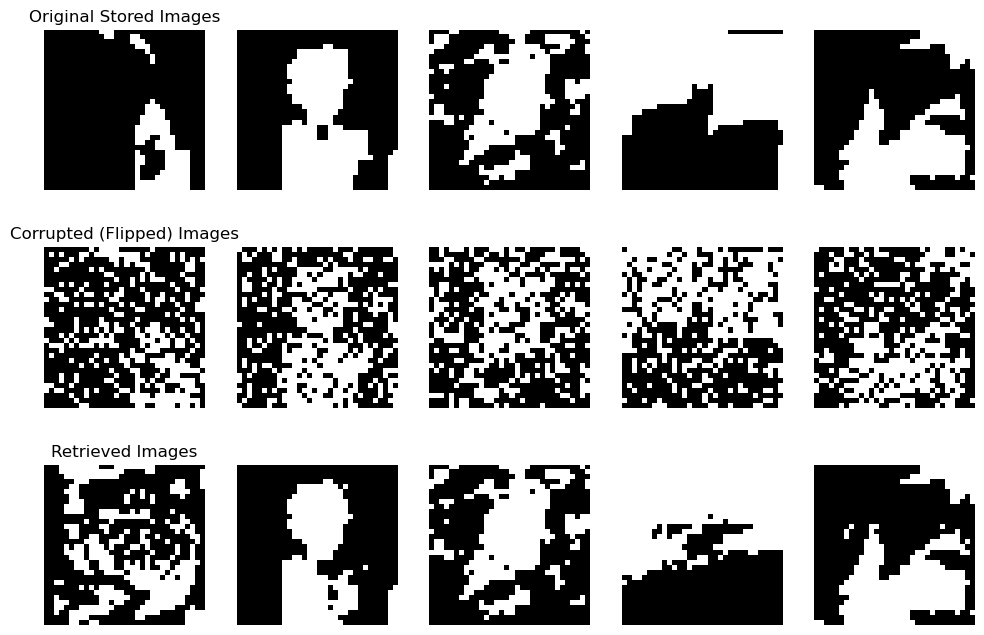

In [29]:
# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked.detach().numpy(),
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped.detach().numpy(),
                 "Corrupted (Flipped) Images", "Retrieved Images")

#### Reconstructing Images for Increasing Stored Patterns

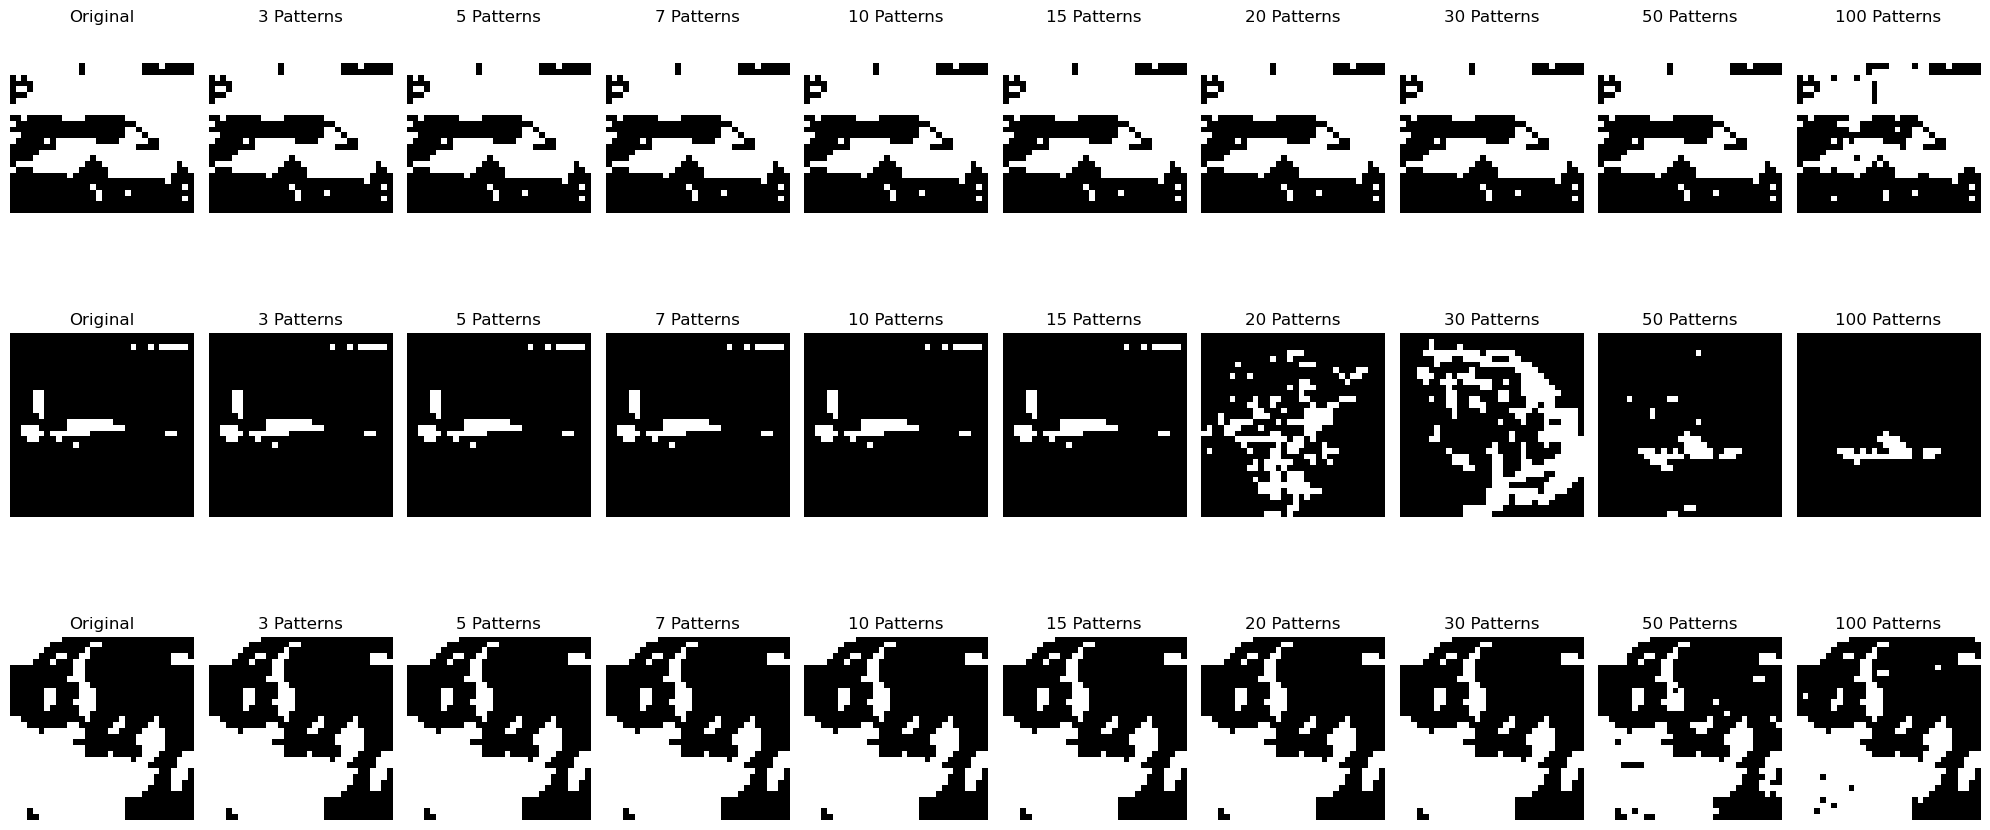

In [31]:
results = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100]
selected_idxs = set()
plot_idx = []
prev_num = 0

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_storkey = storkey.HopfieldStorkey(num_units=1024)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=(num_patterns-prev_num), replace=False)
    prev_num = num_patterns

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_storkey.store_patterns(baseline_original)

    retrieved_masked = hopfield_storkey(baseline_masked)

    # Store the results for plotting later
    results.append(retrieved_masked.detach().numpy())

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


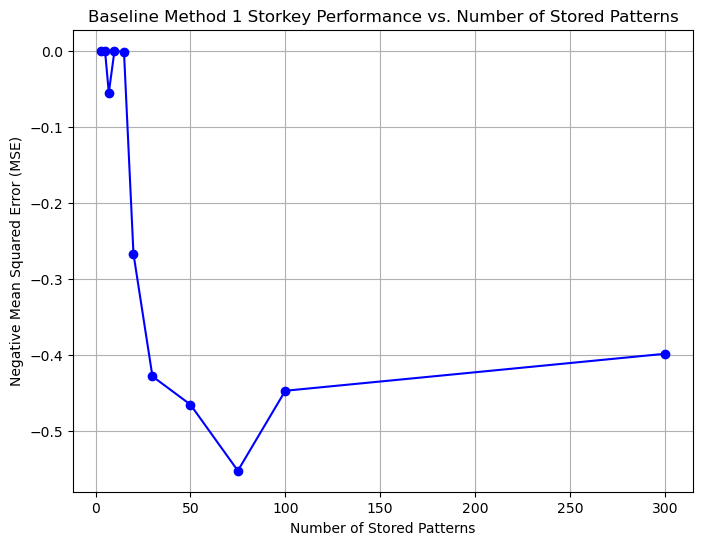

In [40]:
results = []
stor_m1_mse_values = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 75, 100, 300]

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_storkey = storkey.HopfieldStorkey(num_units=1024)

    # randomly select from training set
    idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

    baseline_original = stored_images[idxs]
    baseline_masked = masked_images[idxs]

    hopfield_storkey.store_patterns(baseline_original)

    retrieved_masked = hopfield_storkey(baseline_masked)
    loss = hopfield_storkey.recall_loss(baseline_masked, baseline_original)

    # Store the results for plotting later
    results.append(retrieved_masked.detach().numpy())
    stor_m1_mse_values.append(loss.detach().numpy())

# Plot the negative MSE curve (to make it appear decreasing)
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, [-sse for sse in stor_m1_mse_values], marker='o', linestyle='-', color='b')  # Negative SSE values
plt.title("Baseline Method 1 Storkey Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.grid(True)
plt.show()

### Method 2

Reconstruction MSE Loss (Masked Images): 0.0000
Reconstruction MSE Loss (Flipped Images): 0.0000
--------------------------------------------------
Reconstruction Accuracy (Masked Images): 1.0000
Reconstruction Accuracy (Flipped Images): 1.0000


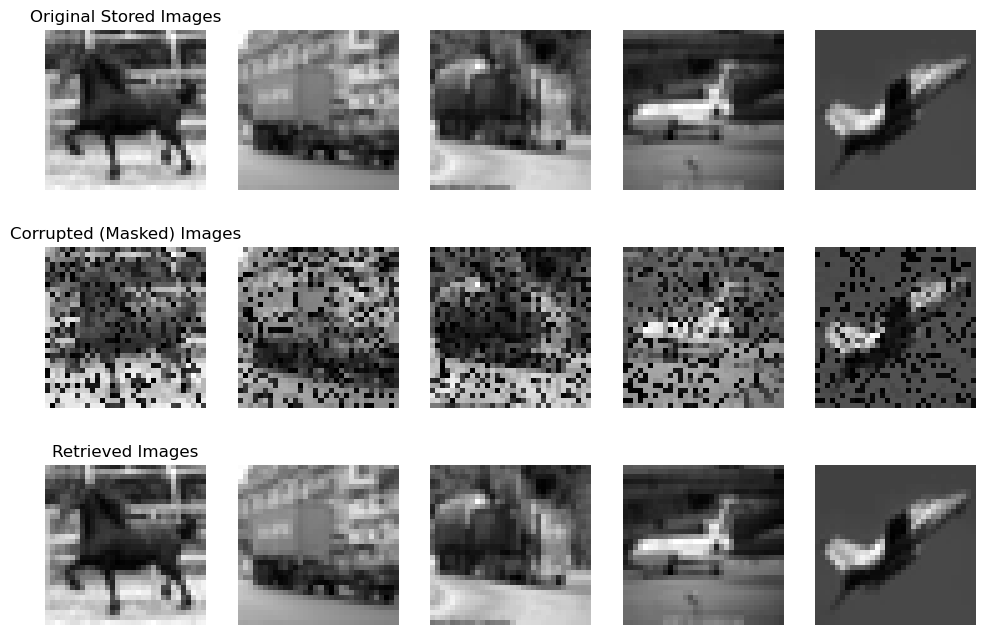

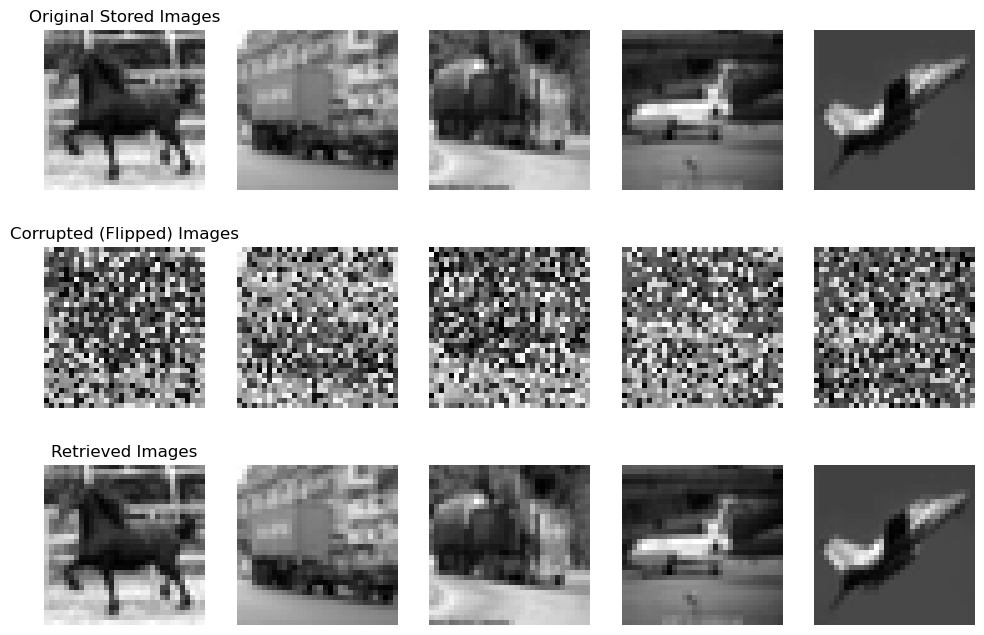

In [15]:
# Method 2 Preprocessing


# load training data
stored_images = np.load("data/grayscale_images/train_images.npy")
masked_images = np.load("data/grayscale_images/masked_images.npy")
flipped_images = np.load("data/grayscale_images/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

importlib.reload(grayscaled_hp_baseline)
importlib.reload(storkey)

num_neurons = 8192
num_patterns = 45
hopfield_storkey = storkey.HopfieldStorkey(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = stored_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_storkey.store_patterns(baseline_original)


# Retrieve images from corrupted inputs
retrieved_masked = hopfield_storkey(baseline_masked).detach()
retrieved_flipped = hopfield_storkey(baseline_flipped).detach()

# Convert back to grayscale
retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])
retrieved_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_flipped])

# Compute MSE Loss
loss_masked = hopfield_storkey.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_storkey.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}")

print('-'*50)

# Compute accuracy
masked_acc = hopfield_storkey.recall_accuracy(baseline_masked, baseline_original)
flipped_acc = hopfield_storkey.recall_accuracy(baseline_flipped, baseline_original)

print(f"Reconstruction Accuracy (Masked Images): {masked_acc:.4f}")
print(f"Reconstruction Accuracy (Flipped Images): {flipped_acc:.4f}")

baseline_original = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_original])
baseline_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_masked])
baseline_flipped = torch.stack([grayscaled_hp_baseline.decode(img) for img in baseline_flipped])

# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked,
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped,
                 "Corrupted (Flipped) Images", "Retrieved Images")


#### Reconstructing Images for Increasing Stored Patterns

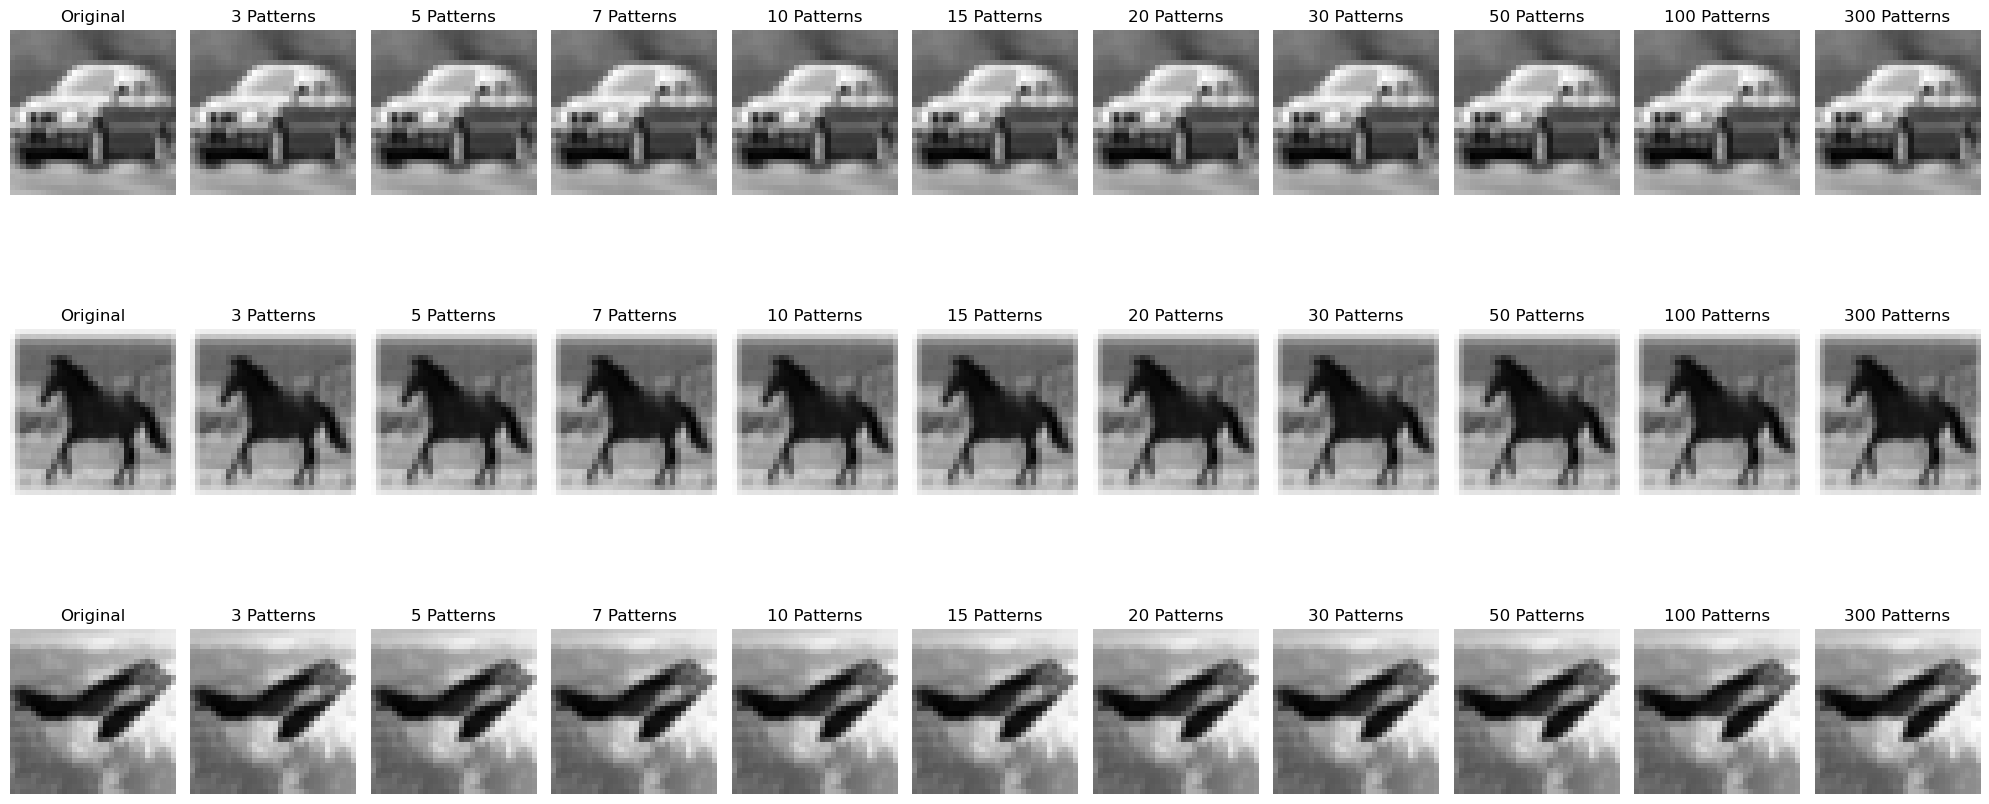

In [37]:
results = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 100, 300]
selected_idxs = set()
plot_idx = []
prev_num = 0

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_storkey = storkey.HopfieldStorkey(num_units=8192)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=(num_patterns-prev_num), replace=False)
    prev_num = num_patterns

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_storkey.store_patterns(baseline_original)

    # Retrieve images from corrupted inputs
    retrieved_masked = hopfield_storkey(baseline_masked).detach()

    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])

    # Store the results for plotting later
    results.append(retrieved_masked)

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(grayscaled_hp_baseline.decode(stored_images[plot_idx[row-1]]), cmap='gray')
    # plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()


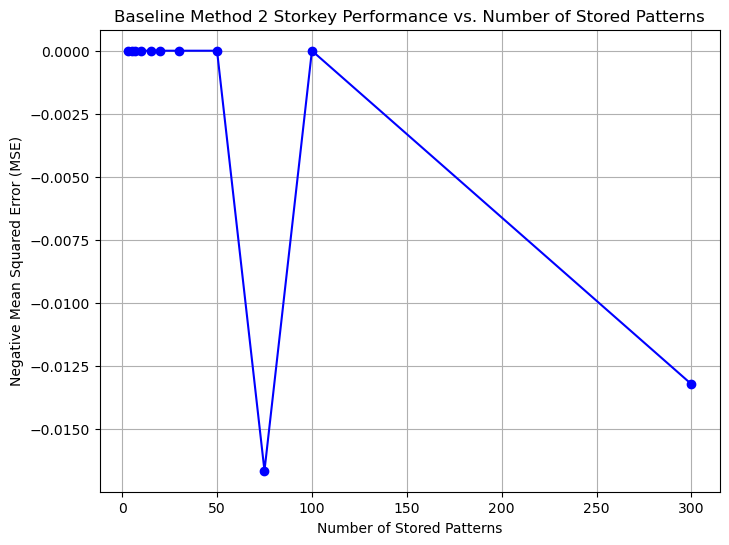

In [16]:
stor_m2_results = []
stor_m2_mse_values = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 75, 100, 300]

for i, num_patterns in enumerate(num_patterns_list):
    
    hopfield_storkey = storkey.HopfieldStorkey(num_units=8192)

    # randomly select from training set
    idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

    baseline_original = stored_images[idxs]
    baseline_masked = masked_images[idxs]

    hopfield_storkey.store_patterns(baseline_original)

    retrieved_masked = hopfield_storkey(baseline_masked).detach()
    
    # Convert back to grayscale
    retrieved_masked = torch.stack([grayscaled_hp_baseline.decode(img) for img in retrieved_masked])

    loss = hopfield_storkey.recall_loss(baseline_masked, baseline_original)

    # Store the results for plotting later
    stor_m2_results.append(retrieved_masked.detach().numpy())
    stor_m2_mse_values.append(loss.detach().numpy())


# Plot the negative MSE curve (to make it appear decreasing)
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, [-mse for mse in stor_m2_mse_values], marker='o', linestyle='-', color='b')  # Negative SSE values
plt.title("Baseline Method 2 Storkey Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.grid(True)
plt.show()

## Training Phase Space Learning

### Method 1


In [47]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

In [17]:
importlib.reload(hopfield_PSL_final)

num_neurons = 1024
num_patterns = 200
epochs = 30
lr = 2e-4
model = hopfield_PSL_final.HopfieldPSL(N=5)

optimizer = optim.Adam(params=model.parameters(), lr=lr)
criterion = nn.MSELoss()

idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)
original = [stored_images[i] for i in idxs]
flipped = [flipped_images[i] for i in idxs]
masked = [masked_images[i] for i in idxs]
targets = [tensor * 0.9 for tensor in original]

In [ ]:
model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for i in range(len(original)):
        optimizer.zero_grad()          # Clear gradients
        output = model(original[i])          # Forward pass

        loss = criterion(output, targets[i])  # Compute reconstruction loss
        
        loss.backward()                  # Backpropagation
        optimizer.step()                 # Update weights
        
        total_loss += loss.item()
    avg_loss = total_loss / len(original)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

Epoch [5/30], Loss: 0.260939
Epoch [10/30], Loss: 0.157179
Epoch [15/30], Loss: 0.097738
Epoch [20/30], Loss: 0.048313
Epoch [25/30], Loss: 0.024641
Epoch [30/30], Loss: 0.018015


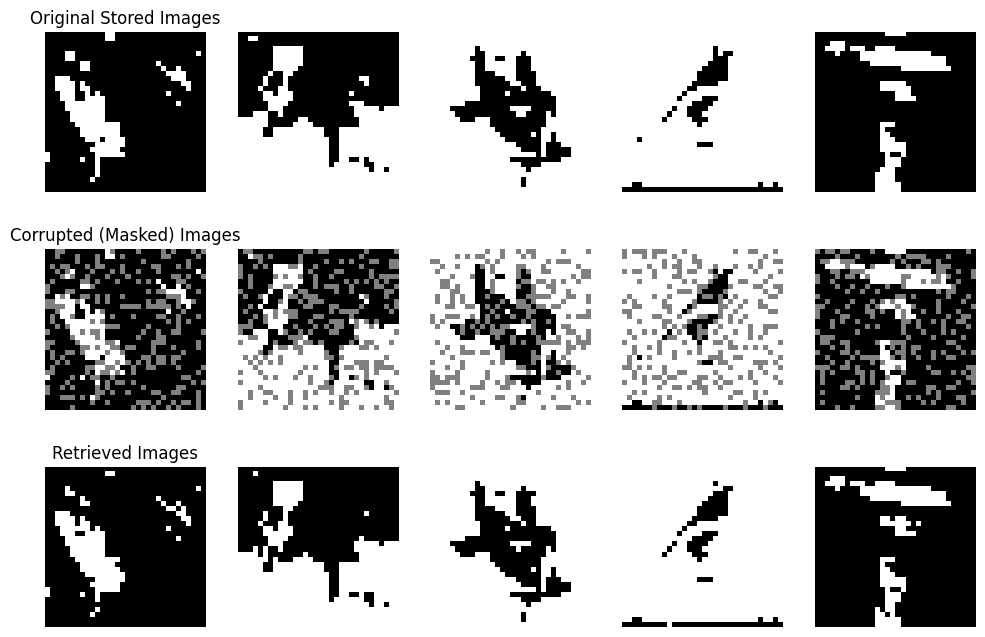

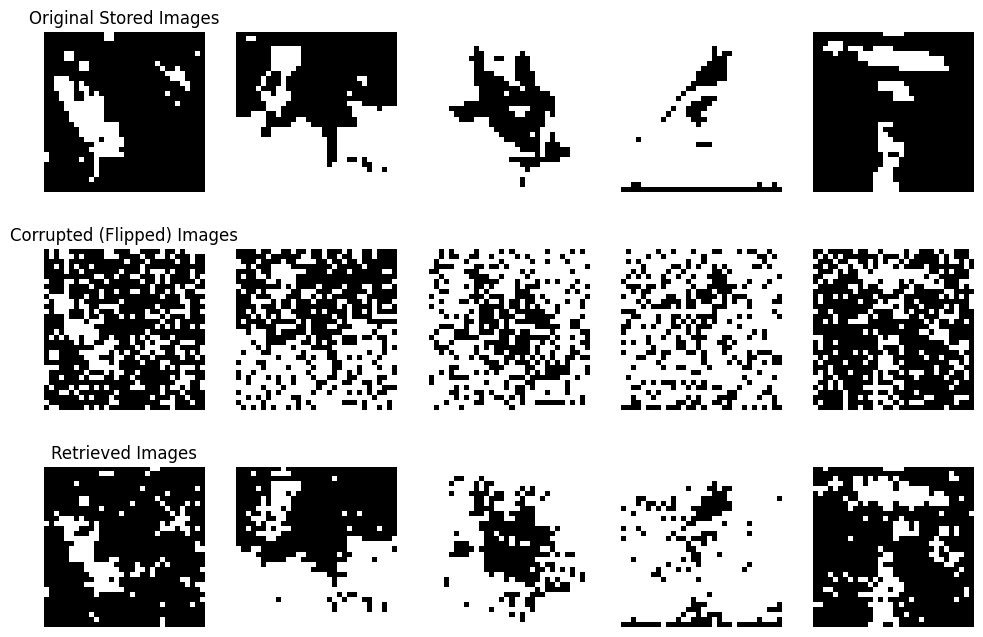

In [ ]:
retrieved_masked = [torch.sign(model(img).detach()).numpy() for img in masked]
retrieved_flipped = [torch.sign(model(img).detach()).numpy() for img in flipped]

plot_comparisons(original, masked, retrieved_masked, "Corrupted (Masked) Images", "Retrieved Images")
plot_comparisons(original, flipped, retrieved_flipped, "Corrupted (Flipped) Images", "Retrieved Images")

#### Reconstructing Images for Increasing Stored Patterns

Processing num_patterns: 100%|██████████| 9/9 [03:13<00:00, 21.50s/it]


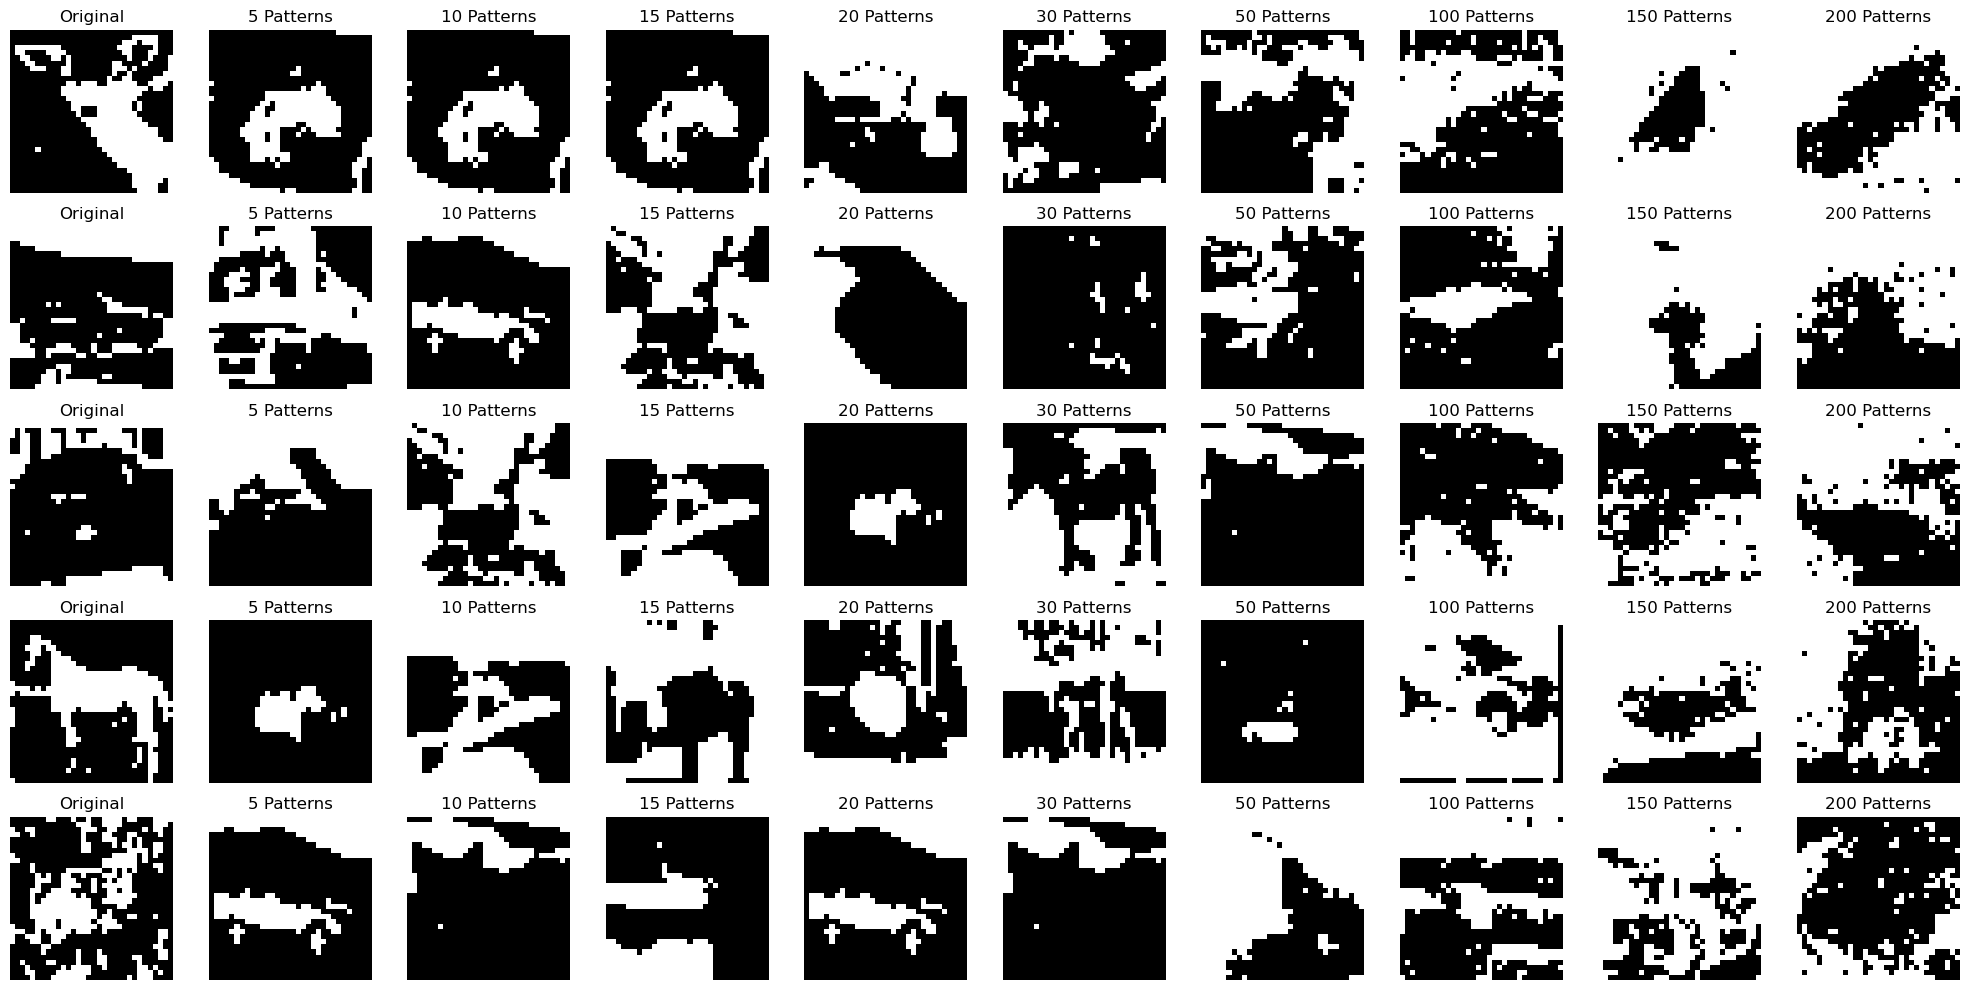

In [ ]:
results = []
num_patterns_list = [5, 10, 15, 20, 30, 50, 100, 150, 200]
selected_idxs = set()
plot_idx = []
prev_num = 0

epochs = 30
lr = 2e-4

criterion = nn.MSELoss()

# funny tanh targets for computing loss
targets = [tensor * 0.9 for tensor in stored_images]

for i, num_patterns in tqdm(enumerate(num_patterns_list), desc="Processing num_patterns", total=len(num_patterns_list)):
    
    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=(num_patterns-prev_num), replace=False)
    prev_num = num_patterns

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[plot_idx]

    hopfield_psl = hopfield_PSL_final.HopfieldPSL(N=5)
    optimizer = optim.Adam(params=hopfield_psl.parameters(), lr=lr)
    
    # train model
    hopfield_psl.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for i in range(len(baseline_original)):
            optimizer.zero_grad()          # Clear gradients
            output = hopfield_psl(baseline_original[i])          # Forward pass

            loss = criterion(output, targets[i])  # Compute reconstruction loss
            
            loss.backward()                  # Backpropagation
            optimizer.step()                 # Update weights
            
            total_loss += loss.item()

    hopfield_psl.eval()

    # Retrieve images from corrupted inputs
    retrieved_masked = [torch.sign(hopfield_psl(img).detach()).numpy() for img in baseline_masked]

    # Store the results for plotting later
    results.append(retrieved_masked)

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()

## Training Spiking

### Plotting Functions

In [18]:
def plot_input_comparisons(original, masked, flipped, title_masked, title_flipped, num_images=5):
    fig, axes = plt.subplots(3, num_images, figsize=(12, 8))

    for i in range(num_images):
        # Original binarized image
        axes[0, i].imshow(original[i].reshape(32, 32), cmap='gray')
        axes[0, i].axis('off')

        # Masked image input
        axes[1, i].imshow(masked[i].reshape(32, 32), cmap='gray')
        axes[1, i].axis('off')

        # Flipped image input
        axes[2, i].imshow(flipped[i].reshape(32, 32), cmap='gray')
        axes[2, i].axis('off')

    # Add row titles
    middle_col = num_images // 2
    axes[0, middle_col].set_title("Original Image", loc='center')
    axes[1, middle_col].set_title(title_masked, loc='center')
    axes[2, middle_col].set_title(title_flipped, loc='center')

    plt.show()

def plot_spiking_data(spikes, rates, pattern_type):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot spike train
    axes[0].eventplot(spikes, colors="black", orientation="vertical")
    axes[0].set_ylim(0, 1024)
    axes[0].set_title(f"{pattern_type} Spike Train")
    axes[0].set_xlabel("Time (ms)")
    axes[0].set_ylabel("Neuron Index")

    # Plot spike rates
    axes[1].bar(range(1024), rates)
    axes[1].set_title(f"{pattern_type} Firing Rates")
    axes[1].set_xlabel("Neuron Index")
    axes[1].set_ylabel("Frequency (Hz)")

    plt.show()

def plot_output_patterns(original, masked, grayscale, binarized, type, num_images=5):
    fig, axes = plt.subplots(4, num_images, figsize=(12, 8))

    for i in range(num_images):
        # Original image
        axes[0, i].imshow(original[i].reshape(32, 32), cmap='gray')
        axes[0, i].axis('off')

        # Masked input
        axes[1, i].imshow(masked[i].reshape(32, 32), cmap='gray')
        axes[1, i].axis('off')

        # Grayscale output
        axes[2, i].imshow(grayscale[i].reshape(32, 32), cmap='gray')
        axes[2, i].axis('off')

        # Binarized output
        axes[3, i].imshow(binarized[i].reshape(32, 32), cmap='gray')
        axes[3, i].axis('off')

    # Add row titles
    middle_col = num_images // 2
    axes[0, middle_col].set_title("Original", loc='center')
    axes[1, middle_col].set_title(f"Corrupted ({type}) Input", loc='center')
    axes[2, middle_col].set_title("Raw Grayscale Output", loc='center')
    axes[3, middle_col].set_title("Binarized Output", loc='center')

    plt.show()

### Method 1

In [43]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

In [22]:
importlib.reload(spiking)

spyking_model = spiking.SpikingHN(N=1024)

num_patterns = 15

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)
spyking_patterns = stored_images[idxs]
spyking_masked = masked_images[idxs]
spyking_flipped = flipped_images[idxs]

spyking_model.train(spyking_patterns)

#### Reconstructing Images for Increasing Stored Patterns

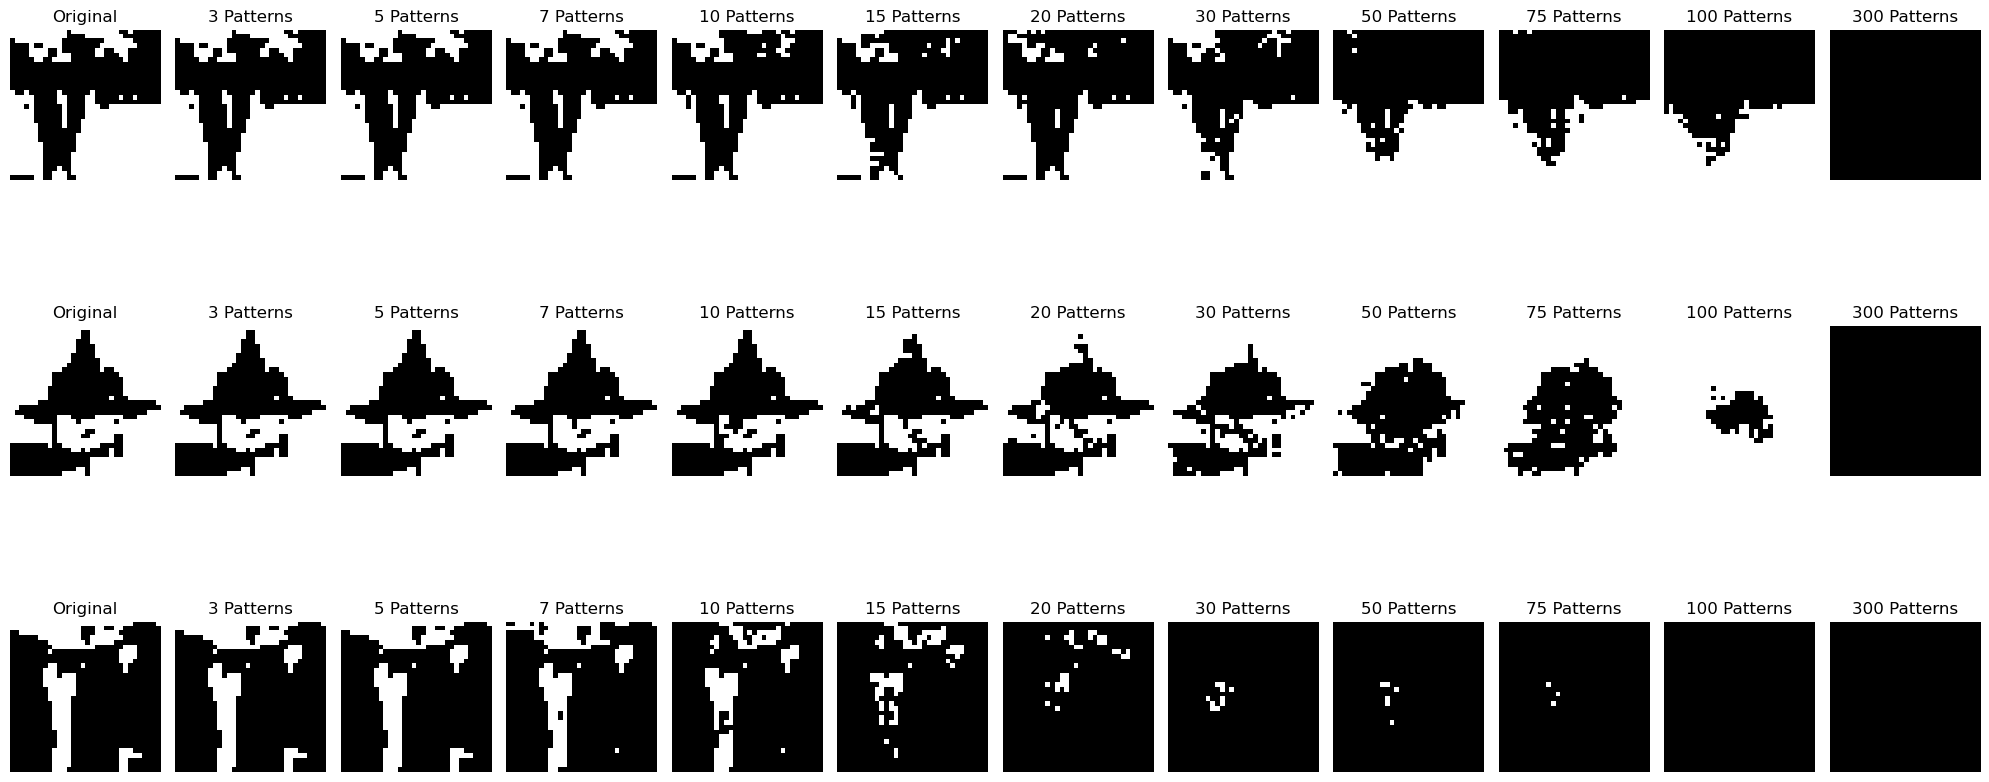

In [ ]:
importlib.reload(spiking)

results = []
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 75, 100, 300]
selected_idxs = set()
plot_idx = []
spiking_mse_values = []
prev_num = 0

for i, num_patterns in enumerate(num_patterns_list):
    
    spiking_hn = spiking.SpikingHN(N=1024)

    # Select new indices that have not been used previously
    remaining_idxs = list(set(range(len(stored_images))) - selected_idxs)  # The remaining available indices
    new_idxs = np.random.choice(remaining_idxs, size=(num_patterns-prev_num), replace=False)
    prev_num = num_patterns

    # Update the set of selected indices
    selected_idxs.update(new_idxs)

    if len(plot_idx) == 0:
        plot_idx = list(selected_idxs)

    baseline_original = stored_images[list(selected_idxs)]
    baseline_masked = masked_images[list(selected_idxs)]
    plotting_masked = masked_images[plot_idx]

    spiking_hn.train(baseline_original)

    retrieved_grayscale, retrieved_binary = spiking_hn.forward(baseline_masked)

    binarized_for_mse = np.where(retrieved_binary == 255, 1, -1)

    baseline_original = torch.tensor(baseline_original, dtype=torch.float32)
    binarized_for_mse = torch.tensor(binarized_for_mse, dtype=torch.float32)

    mse = F.mse_loss(baseline_original, binarized_for_mse)

    plotting_grayscale, plotting_binarized = spiking_hn.forward(plotting_masked)

    # Store the results for plotting later
    results.append(plotting_binarized)
    spiking_mse_values.append(mse)

# Create a large figure with an appropriate size
plt.figure(figsize=(20, 10))

# Loop through the rows (images)
for row, idx in enumerate(plot_idx, start=1):

    # Plot the original image
    plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + 1)
    plt.imshow(stored_images[plot_idx[row-1]].reshape(32,32), cmap='gray')
    plt.title(f'Original')
    plt.axis('off')

    # Plot the retrieved images for each number of patterns
    for i, num_patterns in enumerate(num_patterns_list):

        image_to_plot = results[i][row-1].reshape(32, 32)

        # Plot the image on the appropriate subplot axis
        plt.subplot(len(plot_idx), len(num_patterns_list)+1, (row-1)*(len(num_patterns_list)+1) + (i+2))
        plt.imshow(image_to_plot, cmap='gray')
        plt.title(f'{num_patterns} Patterns')
        plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()

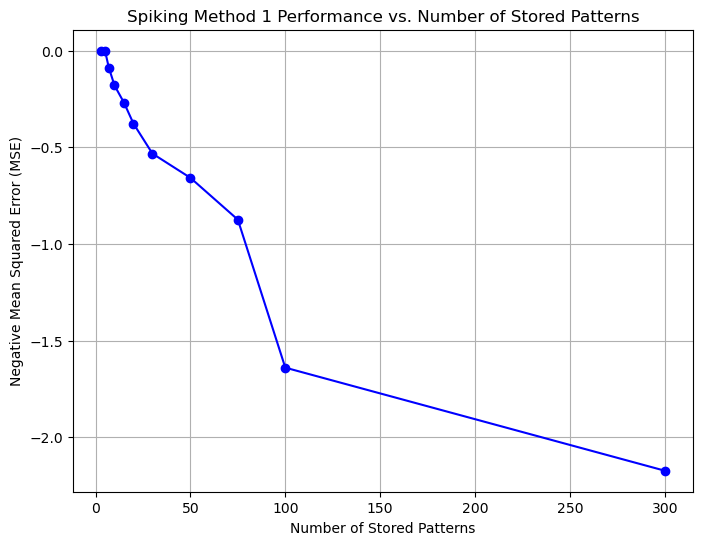

In [47]:
# Plot the negative MSE curve (to make it appear decreasing)
plt.figure(figsize=(8, 6))
plt.plot(num_patterns_list, [-mse for mse in spiking_mse_values], marker='o', linestyle='-', color='b')  # Negative MSE values
plt.title("Spiking Method 1 Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.grid(True)
plt.show()

## Loss Plot for All Models Combined

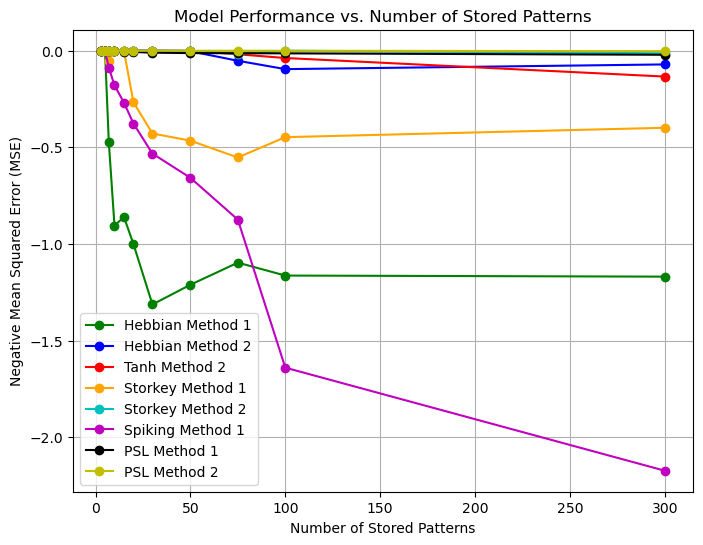

In [48]:
# Plot the negative MSE curve (to make it appear decreasing)
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 75, 100, 300]

plt.figure(figsize=(8, 6))

plt.plot(num_patterns_list, [-mse for mse in hebb_m1_mse_values], marker='o', linestyle='-', color='g', label='Hebbian Method 1')  # Negative SSE values
plt.plot(num_patterns_list, [-mse for mse in hebb_m2_mse_values], marker='o', linestyle='-', color='b', label='Hebbian Method 2')  # Negative SSE values
plt.plot(num_patterns_list, [-mse for mse in tanh_m2_mse_values], marker='o', linestyle='-', color='r', label='Tanh Method 2')  # Negative SSE values
plt.plot(num_patterns_list, [-mse for mse in stor_m1_mse_values], marker='o', linestyle='-', color='orange', label='Storkey Method 1')  # Negative SSE values
plt.plot(num_patterns_list, [-mse for mse in stor_m2_mse_values], marker='o', linestyle='-', color='c', label='Storkey Method 2')  # Negative SSE values
plt.plot(num_patterns_list, [-mse for mse in spiking_mse_values], marker='o', linestyle='-', color='m', label='Spiking Method 1')  # Negative SSE values

binary_PSL_MSE_Loss = {3: 0.000436, 5:0.000730, 7:0.002422, 10:0.003211, 15:0.007486, 20:0.006466, 30:0.01011, 50:0.01235, 75:0.01287, 100:0.01358, 300:0.02094}
binary_psl_mse_values = [-binary_PSL_MSE_Loss[n] for n in num_patterns_list]
plt.plot(num_patterns_list, binary_psl_mse_values, marker='o', linestyle='-', color='k', label='PSL Method 1')  

grayscale_PSL_MSE_Loss = {3: 0.000140, 5:0.000007, 7:0.000012, 10:0.000022, 15:0.000050, 20:0.000068, 30:0.000125, 50:0.000235, 75:0.000204, 100:0.000219, 300:0.002286}
grayscale_psl_mse_values = [-grayscale_PSL_MSE_Loss[n] for n in num_patterns_list]
plt.plot(num_patterns_list, grayscale_psl_mse_values, marker='o', linestyle='-', color='y', label='PSL Method 2')  

plt.title("Model Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()


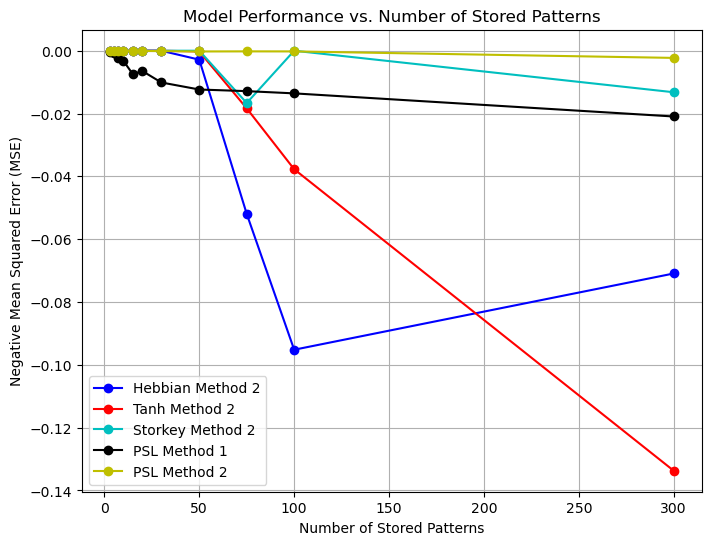

In [49]:
# Plot the negative MSE curve (to make it appear decreasing)
num_patterns_list = [3, 5, 7, 10, 15, 20, 30, 50, 75, 100, 300]

plt.figure(figsize=(8, 6))

#plt.plot(num_patterns_list, [-mse for mse in hebb_m1_mse_values], marker='o', linestyle='-', color='g', label='Hebbian Method 1')  # Negative SSE values
plt.plot(num_patterns_list, [-mse for mse in hebb_m2_mse_values], marker='o', linestyle='-', color='b', label='Hebbian Method 2')  # Negative SSE values
plt.plot(num_patterns_list, [-mse for mse in tanh_m2_mse_values], marker='o', linestyle='-', color='r', label='Tanh Method 2')  # Negative SSE values
#plt.plot(num_patterns_list, [-mse for mse in stor_m1_mse_values], marker='o', linestyle='-', color='orange', label='Storkey Method 1')  # Negative SSE values
plt.plot(num_patterns_list, [-mse for mse in stor_m2_mse_values], marker='o', linestyle='-', color='c', label='Storkey Method 2')  # Negative SSE values
#plt.plot(num_patterns_list, [-mse for mse in spiking_mse_values], marker='o', linestyle='-', color='m', label='Spiking Method 1')  # Negative SSE values

binary_PSL_MSE_Loss = {3: 0.000436, 5:0.000730, 7:0.002422, 10:0.003211, 15:0.007486, 20:0.006466, 30:0.01011, 50:0.01235, 75:0.01287, 100:0.01358, 300:0.02094}
binary_psl_mse_values = [-binary_PSL_MSE_Loss[n] for n in num_patterns_list]
plt.plot(num_patterns_list, binary_psl_mse_values, marker='o', linestyle='-', color='k', label='PSL Method 1')  

grayscale_PSL_MSE_Loss = {3: 0.000140, 5:0.000007, 7:0.000012, 10:0.000022, 15:0.000050, 20:0.000068, 30:0.000125, 50:0.000235, 75:0.000204, 100:0.000219, 300:0.002286}
grayscale_psl_mse_values = [-grayscale_PSL_MSE_Loss[n] for n in num_patterns_list]
plt.plot(num_patterns_list, grayscale_psl_mse_values, marker='o', linestyle='-', color='y', label='PSL Method 2')  

plt.title("Model Performance vs. Number of Stored Patterns")
plt.xlabel("Number of Stored Patterns")
plt.ylabel("Negative Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()
